In [1]:
import os, shutil, sys, bottleneck as bn, numpy as np, matplotlib.pyplot as plt, seaborn as sn, pandas as pd, tensorflow as tf
from scipy import sparse
from tensorflow.contrib.layers import apply_regularization, l2_regularizer
from tqdm import tqdm 
%matplotlib inline
sn.set()

/home/anand_vishal2994/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

class MultiVAE(MultiDAE):
    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        self._construct_weights()
        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)
        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]
                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))
        sampled_z = mu_q + self.is_training_ph * epsilon * std_q
        logits = self.p_graph(sampled_z)
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []
        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(stddev=0.001, seed=self.random_seed)))
            
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])
    
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

def filter_triplets(tp, min_uc=5, min_sc=0):
    if min_sc > 0:
        itemcount = get_count(tp, 'track_id')
        tp = tp[tp['track_id'].isin(itemcount.index[itemcount >= min_sc])]
        
    if min_uc > 0:
        usercount = get_count(tp, 'user_id')
        tp = tp[tp['user_id'].isin(usercount.index[usercount >= min_uc])]
    
    usercount, itemcount = get_count(tp, 'user_id'), get_count(tp, 'track_id') 
    return tp, usercount, itemcount

def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('user_id')
    tr_list, te_list = list(), list()
    np.random.seed(98765)
    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    tp = 1. / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True
    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [3]:
DATA_DIR = './mpd_proc'
pro_dir = os.path.join(DATA_DIR, 'data_large')

'''
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'raw_df.csv'), header=0, index_col=0)
print(raw_data.head())
raw_data, user_activity, item_popularity = filter_triplets(raw_data)
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])
print("After filtering, there are %d playlist inclusion events from %d playlist and %d tracks (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))
unique_uid = user_activity.index
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
n_users = unique_uid.size
n_heldout_users = 10000
tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]
train_plays = raw_data.loc[raw_data['user_id'].isin(tr_users)]
unique_sid = pd.unique(train_plays['track_id'])
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)
vad_plays = raw_data.loc[raw_data['user_id'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['track_id'].isin(unique_sid)]
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)
test_plays = raw_data.loc[raw_data['user_id'].isin(te_users)]
test_plays = test_plays.loc[test_plays['track_id'].isin(unique_sid)]
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['user_id']))
    sid = list(map(lambda x: show2id[x], tp['track_id']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)
'''
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1
    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype='float64', shape=(n_users, n_items))
    return data
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)
    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())
    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']
    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'), os.path.join(pro_dir, 'validation_te.csv'))
N = train_data.shape[0]
idxlist = list(range(N))
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))
N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)
batch_size_vad = 2000
total_anneal_steps = 200000
anneal_cap = 0.2
p_dims = [200, 600, n_items]
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)
saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()
ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))
log_dir = 'log/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())
chkpt_dir = 'log/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)
n_epochs = 30

INFO:tensorflow:Scale of 0 disables regularizer.
log directory: log/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I
chkpt directory: log/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [4]:
ndcgs_vad = []
idxlist = list(idxlist)
with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)
    best_ndcg = -np.inf
    update_count = 0.0
    
    for epoch in tqdm(range(n_epochs)):
        np.random.shuffle(idxlist)
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        print ("NDCG: {}".format(ndcg_))
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

  0%|          | 0/30 [00:00<?, ?it/s]

NDCG: 0.2528028233088182


  3%|▎         | 1/30 [1:01:03<29:30:55, 3663.97s/it]

NDCG: 0.2773385169348196


  7%|▋         | 2/30 [2:01:52<28:26:11, 3656.13s/it]

NDCG: 0.28514107836128355


 10%|█         | 3/30 [3:02:29<27:22:23, 3649.76s/it]

NDCG: 0.2877635102507659


 13%|█▎        | 4/30 [4:02:20<26:15:16, 3635.25s/it]

NDCG: 0.2894289363483962


 17%|█▋        | 5/30 [5:02:28<25:12:23, 3629.74s/it]

NDCG: 0.29026740384714667


 20%|██        | 6/30 [6:02:32<24:10:08, 3625.36s/it]

NDCG: 0.2906367374929651


 23%|██▎       | 7/30 [7:04:42<23:15:27, 3640.34s/it]

NDCG: 0.2923091770234611


 27%|██▋       | 8/30 [8:06:18<22:17:20, 3647.30s/it]

NDCG: 0.2935296211985771


 30%|███       | 9/30 [9:08:21<21:19:29, 3655.69s/it]

NDCG: 0.2940164279388915


 33%|███▎      | 10/30 [10:10:03<20:20:06, 3660.31s/it]

NDCG: 0.2950775339477392


 37%|███▋      | 11/30 [11:10:07<19:17:29, 3655.26s/it]

NDCG: 0.2952978016679643


 40%|████      | 12/30 [12:11:27<18:17:11, 3657.30s/it]

NDCG: 0.2959812079627227


 43%|████▎     | 13/30 [13:11:57<17:15:37, 3655.16s/it]

NDCG: 0.29632774578176385


 47%|████▋     | 14/30 [14:12:09<16:13:53, 3652.09s/it]

NDCG: 0.2973348004488285


 50%|█████     | 15/30 [15:12:06<15:12:06, 3648.47s/it]

NDCG: 0.297735507509952


 53%|█████▎    | 16/30 [16:12:52<14:11:16, 3648.31s/it]

NDCG: 0.29857936849030725


 57%|█████▋    | 17/30 [17:14:27<13:11:03, 3651.01s/it]

NDCG: 0.2988425475904765


 63%|██████▎   | 19/30 [19:19:28<11:11:16, 3661.51s/it]

NDCG: 0.29879389587195565
NDCG: 0.2992937517762903


 67%|██████▋   | 20/30 [20:20:19<10:10:09, 3661.00s/it]

NDCG: 0.30042770327091356


 73%|███████▎  | 22/30 [22:22:58<8:08:21, 3662.66s/it] 

NDCG: 0.3001702678914034
NDCG: 0.3011571315079568


 80%|████████  | 24/30 [24:24:24<6:06:06, 3661.04s/it]

NDCG: 0.3004840363856095


 83%|████████▎ | 25/30 [25:25:31<5:05:06, 3661.26s/it]

NDCG: 0.30107621088313996


 87%|████████▋ | 26/30 [26:28:05<4:04:19, 3664.84s/it]

NDCG: 0.3008230754160175
NDCG: 0.3013458507887182


 90%|█████████ | 27/30 [27:29:59<3:03:19, 3666.64s/it]

NDCG: 0.3021236588708264


 97%|█████████▋| 29/30 [29:34:21<1:01:11, 3671.07s/it]

NDCG: 0.30194381656071817


100%|██████████| 30/30 [30:36:14<00:00, 3672.49s/it]  

NDCG: 0.3015307420706739


INFO:tensorflow:Scale of 0 disables regularizer.
chkpt directory: log/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I
INFO:tensorflow:Restoring parameters from log/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I/model


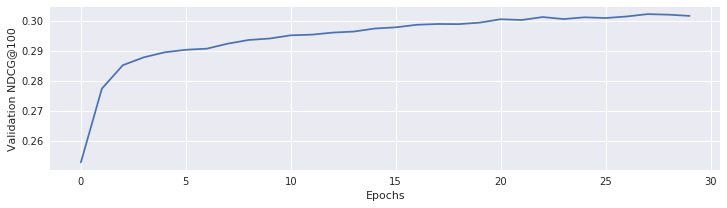

In [7]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")

test_data_tr,test_data_te=load_tr_te_data(os.path.join(pro_dir,'test_tr.csv'),os.path.join(pro_dir,'test_te.csv'))

N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)
batch_size_test = 2000
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()
#chkpt_dir = 'chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
chkpt_dir = 'log/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)
n100_list, r20_list, r50_list, r100_list = [], [], [], []
chkpt_dir_1 = "log/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I"
with tf.Session() as sess:
    #saver.restore(sess, '{}/model'.format(chkpt_dir))
    saver.restore(sess, '{}/model'.format(chkpt_dir_1))
    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]
        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')
        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
        r100_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)
r100_list = np.concatenate(r100_list)


In [8]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))
print("Test Recall@100=%.5f (%.5f)" % (np.mean(r100_list), np.std(r100_list) / np.sqrt(len(r100_list))))


Test NDCG@100=0.30001 (0.00099)
Test Recall@20=0.24256 (0.00102)
Test Recall@50=0.34199 (0.00114)
Test Recall@100=0.43905 (0.00120)
